In [447]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

%matplotlib inline

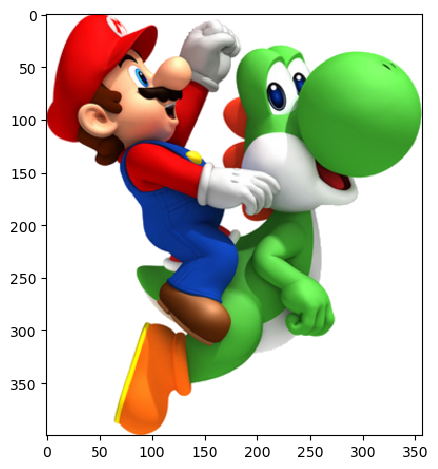

In [448]:
img = skimage.io.imread('mario.png')
img = np.array(img[:,:,:3], dtype='float64') / 255
skimage.io.imshow(img)

In [449]:
img.shape

(400, 357, 3)

In [450]:
def initial_population(img_size, population_size):
    pop = np.zeros((population_size, *img_size))
    for sample in pop:
        background_color = np.random.random(3)
        sample[:, :] = background_color
        for _ in range(np.random.randint(100, 200)):
            block_width = np.random.randint(0.01*img_size[0], 0.1*img_size[0])
            start_width = np.random.randint(img_size[0])
            end_width = start_width
            if start_width + block_width >= img_size[0]:
                end_width -= block_width
            elif start_width - block_width < 0:
                end_width += block_width
            else:
                end_width += np.random.choice([-1, 1])*block_width
            if start_width > end_width:
                start_width, end_width = end_width, start_width
                
            block_height = np.random.randint(0.01*img_size[1], 0.1*img_size[1])
            start_height = np.random.randint(img_size[1])
            end_height = start_height
            if start_height + block_height >= img_size[1]:
                end_height -= block_height
            elif start_height - block_height < 0:
                end_height += block_height
            else:
                end_height += np.random.choice([-1, 1])*block_height
            if start_height > end_height:
                start_height, end_height = end_height, start_height
            
            sample[start_width:end_width, start_height:end_height] = np.random.random(3)
        
    return pop

In [503]:
i = 0
x = initial_population(img.shape, 100)

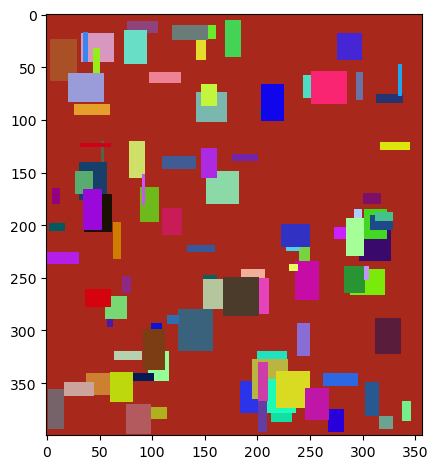

In [506]:
skimage.io.imshow(x[i])
i += 1

In [507]:
def fitness(gt, chromosome, block_size):
    block_size = (*block_size, *gt.shape[2:])
    ch_ = skimage.measure.block_reduce(chromosome, block_size, np.mean)
    gt_ = skimage.measure.block_reduce(gt, block_size, np.mean)
    
    err = ch_ - gt_
    err = np.sum(err**2)
    
    return err

In [508]:
i = 0

In [514]:
f = fitness(img, x[i], (15,15))
i += 1
f

71.5961264554974

In [517]:
def selection(gt, population, tournament_size, best_size):
    population_size = population.shape[0]
    best_size = int(population_size*best_size)
    tournament_size = int(population_size*tournament_size)
    
    best = np.zeros((best_size, *population.shape[1:]))
    for i in range(best_size):
        cands = np.random.choice(range(population_size), tournament_size)
        cands = population[cands]
        best_cand, best_fit = cands[0], fitness(gt, cands[0], (15,15))
        for cand in cands[1:]:
            fit = fitness(gt, cand, (15,15))
            if fit < best_fit:
                best_fit = fit
                best_cand = cand
                
        best[i] = best_cand
    
    return best

In [518]:
best = selection(img, x, 0.08, 0.2)

In [ ]:
def crossover()